# Overview Notes

### Classification
* Classification using logistic regression
* Binary classification
* Multiclass classification
<br/><br/>

### Formalisms

#### **Definition of classification problem**

$P(Y=i|x,w,b) = \phi(z)$

where
* $Y$ - output
* $i$ - one of the classes
* $x$ - inputs
* $w$ - weights
* $b$ - biases
* $\phi(.)$ - model function
* $z = w \times x + b$

Model is trained **to maximise the probability** $P$.
<br/><br/>

#### **Logistic regression (binary classification)**

$\phi(z) = \frac{1}{1 - e^{-z}}$ where $z = w \times x + b$

Note sigmoid function, range $[0, 1]$:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" width=350/>

*Loss function*

* Maximise LIKELIHOOD --> 
* Maximise LOG-LIKELIHOOD (simpler, with sums) --> 
* *Minimise* NEGATIVE LOG-LIKELIHOOD --> 
* In this case it's just binary corss-entropy:

$J(w) = -l(w) = - \sum_{j=1}^{j=N} [ y_j \log(\phi(z_j) + (1 - y_j) \log( 1 - \phi(z_j) ) ])$

* $j$ iterates over **examples**
* $z = w \times x + b$
* $-l(w)$ being negative log-likelihood
* techinically $(w)$ refers to both $w,b$
<br/><br/>

#### **Logistic regression (multiclass classification)**

Multiclass case necessitates a different final ("smoothing") function applied (not sigmoid): **softmax**.

**Softmax *for class $i$* among classes iterated by $c$:**

$\phi(z_i) = softmax(z_i) = \frac{e_{i}^{z}}{\sum_{c=1}^{c=C} e_{c}^{z}}$

* $c$ iterates over **classes**
* $i$: specific class
* $z = w \times x + b$

Softmax function produces the probabilities for each class, and the probabilities vector adds to 1. While predicting, the class with highest softmax value becomes the output or predicted class.

*Loss function*

Negative log-likelihood, as before; this time it looks like:

$J(w) = -l(w) = - \sum_{j=1}^{j=N} [ y_j \log(\phi(z_j)) ])$

* Same definitions as above.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#With-Generated-Dataset" data-toc-modified-id="With-Generated-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>With Generated Dataset</a></span><ul class="toc-item"><li><span><a href="#Generate-the-dataset" data-toc-modified-id="Generate-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate the dataset</a></span></li></ul></li><li><span><a href="#With-MNIST-dataset" data-toc-modified-id="With-MNIST-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With MNIST dataset</a></span><ul class="toc-item"><li><span><a href="#Get-the-MNIST-data" data-toc-modified-id="Get-the-MNIST-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get the MNIST data</a></span></li><li><span><a href="#Simple-MNIST-Classification-with-Logistic-Regression" data-toc-modified-id="Simple-MNIST-Classification-with-Logistic-Regression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Simple MNIST Classification with Logistic Regression</a></span></li>

# Classification with TensorFlow <a class="tocSkip">

In [1]:
import tensorflow as tf
print('TensorFlow:{}'.format(tf.__version__))
tf.set_random_seed(123)

import numpy as np
print('NumPy:{}'.format(np.__version__))
np.random.seed(123)

import matplotlib.pyplot as plt

import sklearn
print('Scikit Learn:{}'.format(sklearn.__version__))
import sklearn.model_selection
import sklearn.datasets

import os

TensorFlow:1.15.5
NumPy:1.18.5
Scikit Learn:0.24.2


### DatasetsLib stuff:

In [2]:
DATASETSLIB_HOME = '../datasetslib'

In [3]:
import sys

if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)

%reload_ext autoreload
%autoreload 2

import datasetslib

In [4]:
datasetslib.datasets_root = os.path.abspath('../datasets')

# With Generated Dataset

## Generate the dataset 

Note on `sklearn.datasets.make_classification()`:

```python
n_features : int, default=20
    The total number of features. These comprise ``n_informative``
    informative features, ``n_redundant`` redundant features,
    ``n_repeated`` duplicated features and
    ``n_features-n_informative-n_redundant-n_repeated`` useless features
    drawn at random.
```

### Small dataset

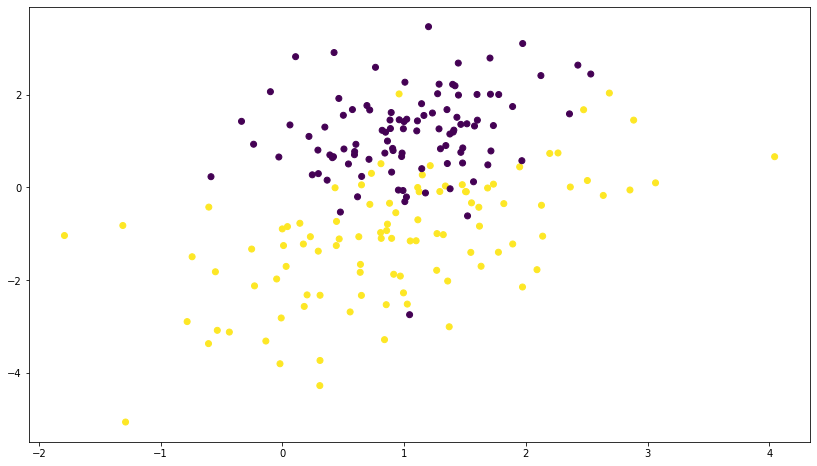

In [5]:
num_output_features = 2
num_input_features = 2

np.random.seed(1)

X, y = sklearn.datasets.make_classification(
    n_samples=200,
    n_features=num_input_features,
    n_informative=2,  # Note.
    n_redundant=0,
    n_repeated=0,
    n_classes=num_output_features,
    n_clusters_per_class=1  # Note.
)

plt.figure(figsize=(14, 8))
plt.scatter(
    X[:, 0], 
    X[:, 1], 
    marker='o', 
    c=y  # Note: colour indication.
)
plt.show()

In [6]:
# One-hot encoding - using `np.eye()`
print(y[0:5])

# Note:
# np.eye(2):
# [[1 0] 
#  [0 1]]
# If you then take the y_i'th element for *each example*, you get one-hot, e.g.:
# y = [0 1 1 1 1]
# y_one_hot = 
# [[1. 0.]
#  [0. 1.]
#  [0. 1.]
#  [0. 1.]
#  [0. 1.]]
y = np.eye(num_output_features)[y]
print(y[0:5])

[0 1 1 1 1]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, 
    y, 
    test_size=.4, 
    random_state=42
)

In [8]:
num_output_features = y_train.shape[1]
num_input_features = X_train.shape[1]

learning_rate = 0.001

# inputs
x = tf.placeholder(dtype=tf.float32, shape=[None, num_input_features], name="x")
# output labels
y = tf.placeholder(dtype=tf.float32, shape=[None, num_output_features], name="y")

# model paramteres
w = tf.Variable(tf.zeros([num_input_features, num_output_features]), name="w")
b = tf.Variable(tf.zeros([num_output_features]), name="b")
model = tf.nn.sigmoid(tf.matmul(x, w) + b)

In [9]:
loss = tf.reduce_mean(  # Take a mean across *examples*.
    # Binary cross-entropy:
    -tf.reduce_sum(
        (y * tf.log(model)) + ((1 - y) * tf.log(1 - model)), 
        axis=1  # <-- NOTE.
    )
)

In [10]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

preds_check Tensor("Equal:0", shape=(80,), dtype=bool)
epoch 0000  accuracy=0.91250002


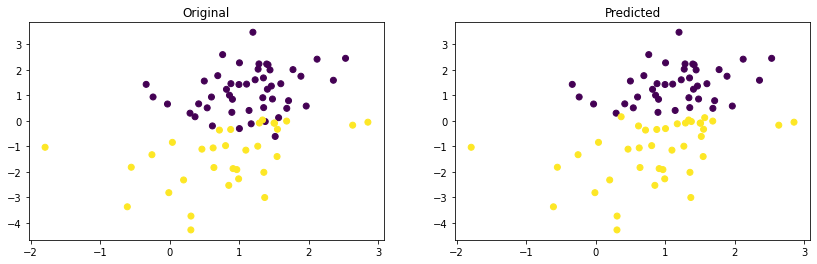

In [11]:
num_epochs = 1  # BTW, only one pass through data here.

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
        # --- Training ---
        tfs.run(optimizer, feed_dict={x: X_train, y: y_train})  # Note `placeholder`s as keys!
        
        # --- Evaluation ---
        
        # Note:
        # tf.argmax(model, axis=1): to find the highest prob. class.
        # tf.argmax(y, axis=1): to just identify the true class from the one-hot encoding.
        y_pred = tfs.run(
            tf.argmax(model, axis=1), 
            feed_dict={x: X_test}
        )
        y_orig = tfs.run(
            tf.argmax(y, axis=1), 
            feed_dict={y: y_test}
        )
        
        preds_check = tf.equal(y_pred, y_orig)  # Vector stating whether the prediction was the right class.
        print("preds_check", preds_check)
        accuracy_op = tf.reduce_mean(tf.cast(preds_check, tf.float32))  # Compute the accuracy metric.
        accuracy_score = tfs.run(accuracy_op)
        print("epoch {0:04d}  accuracy={1:.8f}".format(epoch, accuracy_score))
        
        # Plot original data vs predicted.
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_orig)
        plt.title('Original')
        plt.subplot(1, 2, 2)
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_pred)
        plt.title('Predicted')
        plt.show()

### Large dataset

In [12]:
X, y = sklearn.datasets.make_classification(
    n_samples=20000,
    n_features=200,
    n_informative=200, 
    n_redundant=0, 
    n_repeated=0,
    n_classes=2,  # Note.
    n_clusters_per_class=1
)

print("X.shape:", X.shape, "y.shape:", y.shape)

X.shape: (20000, 200) y.shape: (20000,)


In [13]:
num_classes = np.max(y) + 1
print("num_classes:", num_classes)

print(y[:10])
y=np.eye(num_classes)[y]
print(y[:10])

num_classes: 2
[1 0 0 0 0 1 0 1 1 1]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.4, random_state=42)
print(X_train.shape, y_test.shape)

(12000, 200) (8000, 2)


In [15]:
num_output_features = y_train.shape[1] 
num_input_features = X_train.shape[1]

learning_rate = 0.001

# inputs
x = tf.placeholder(dtype=tf.float32, shape=[None, num_input_features], name="x") 
# output labels
y = tf.placeholder(dtype=tf.float32, shape=[None, num_output_features], name="y") 

# model paramteres 
w = tf.Variable(tf.zeros([num_input_features,num_output_features]), name="w")        
b = tf.Variable(tf.zeros([num_output_features]), name="b")             
model = tf.nn.sigmoid(tf.matmul(x, w) + b)  # Note where sigmoid resides: tf.nn.sigmoid

In [16]:
# loss function
loss = tf.reduce_mean(
    -tf.reduce_sum(
        ( y * tf.log(model)) + ( (1-y)*tf.log(1-model) ), 
        axis=1
    )
)

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [18]:
from tqdm.notebook import tqdm

  0%|          | 0/500 [00:00<?, ?it/s]

After 0500 epoch,  accuracy=0.93112499


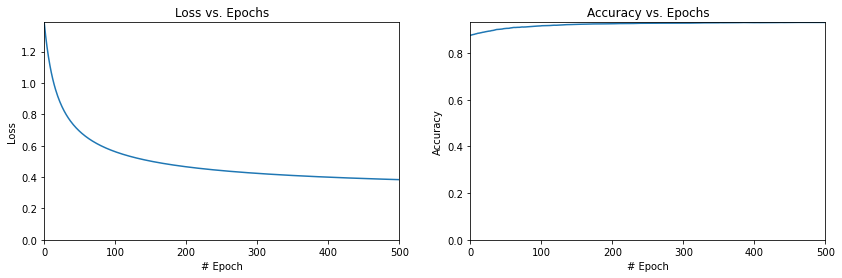

In [19]:
num_epochs = 500

loss_epochs = np.empty(shape=[num_epochs], dtype=float)
accuracy_epochs = np.empty(shape=[num_epochs], dtype=float)

accuracy_score = 0

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    
    for epoch in tqdm(range(num_epochs)):
        _, loss_val = tfs.run([optimizer, loss], feed_dict={x: X_train, y: y_train})  # Optimizer step, get loss.
        
        y_pred = tfs.run(tf.argmax(model, axis=1), feed_dict={x: X_test})
        y_orig = tfs.run(tf.argmax(y, axis=1), feed_dict={y: y_test})

        predictions_check = tf.equal(y_pred, y_orig)
        accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))
        accuracy_score = tfs.run(accuracy_function)
        
        # Record:
        accuracy_epochs[epoch] = accuracy_score
        loss_epochs[epoch] = loss_val

print("After {0:04d} epoch,  accuracy={1:.8f}".format(num_epochs,accuracy_score))

# Plot loss (train) and accuracy (test)
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs)
plt.title('Loss vs. Epochs')
plt.xlabel('# Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.axis([0,num_epochs,0,np.max(accuracy_epochs)])
plt.plot(accuracy_epochs)
plt.title('Accuracy vs. Epochs')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')

plt.show()

# With MNIST dataset

## Get the MNIST data

In [20]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets(
    os.path.join(datasetslib.datasets_root, 'mnist'), 
    one_hot=True
)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /mnt/space/Dropbox/Programming/wsl_repos/_forked/Mastering-TensorFlow-1x/datasets/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /mnt/space/Dropbox/Programming/wsl_repos/_forked/Mastering-TensorFlow-1x/datasets/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /mnt/space/Dropbox/Programming/wsl_repos/_forked/Mastering-TensorFlow-1x/dataset

## Simple MNIST Classification with Logistic Regression

In [23]:
num_output_features = 10  # 0-9 digits
num_input_features = 784  # total pixels

learning_rate = 0.001
num_epochs = 1
batch_size = 100

num_batches = int(mnist.train.num_examples / batch_size)
print(num_batches)

550


In [24]:
# input images
x = tf.placeholder(dtype=tf.float32, shape=[None, num_input_features], name="x")
# output labels
y = tf.placeholder(dtype=tf.float32, shape=[None, num_output_features], name="y")

# model paramteres
w = tf.Variable(tf.zeros([num_input_features, num_output_features]), name="w")
b = tf.Variable(tf.zeros([num_output_features]), name="b")

In [26]:
model = tf.nn.softmax(tf.matmul(x, w) + b)  # NOTE: Using softmax here!

In [27]:
# ---------------------------------------
# Loss - using categorical cross-entropy
# ---------------------------------------

loss = tf.reduce_mean(
    -tf.reduce_sum(
        y * tf.log(model),
        axis=1
    )
)

In [28]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [29]:
with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
        
        # --- TRAINING ---
        for batch in range(num_batches):
            # Note that we're now batch-iterating.
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            tfs.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        # --- EVALUATION ---
        predictions_check = tf.equal(
            tf.argmax(model, axis=1), 
            tf.argmax(y, axis=1)
        )
        accuracy_function = tf.reduce_mean(
            tf.cast(predictions_check, tf.float32)
        )
        feed_dict = {x: mnist.test.images, y: mnist.test.labels}  # Feed the whole test dataset at eval. time.
        accuracy_score = tfs.run(accuracy_function, feed_dict)
        print("epoch {0:04d}  accuracy={1:.8f}".format(epoch, accuracy_score))

epoch 0000  accuracy=0.75950003


#### Now put MNIST multi-class classification into a convenience funciton:

In [30]:
def mnist_batch_func(batch_size=100):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    return [batch_x, batch_y]


def tensorflow_classification(
    num_epochs, 
    num_batches, 
    batch_size,
    batch_func, 
    optimizer, 
    test_x, 
    test_y
):
    accuracy_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
    with tf.Session() as tfs:
        tf.global_variables_initializer().run()
        
        for epoch in range(num_epochs):
            
            # Train...
            for batch in range(num_batches):
                batch_x, batch_y = batch_func(batch_size)
                feed_dict = {x: batch_x, y: batch_y}
                tfs.run(optimizer, feed_dict)
            
            # Eval...
            predictions_check = tf.equal(
                tf.argmax(model, axis=1), 
                tf.argmax(y, axis=1)
            )
            accuracy_function = tf.reduce_mean(
                tf.cast(predictions_check, tf.float32)
            )
            feed_dict = {x: test_x, y: test_y}
            accuracy_score = tfs.run(accuracy_function, feed_dict)
            accuracy_epochs[epoch] = accuracy_score
            print("epoch {0:04d}  accuracy={1:.8f}".format(epoch, accuracy_score))

    plt.figure(figsize=(14, 8))
    plt.axis([0, num_epochs, np.min(accuracy_epochs), np.max(accuracy_epochs)])
    plt.plot(accuracy_epochs, label='Accuracy Score')
    plt.title('Accuracy over Iterations')
    plt.xlabel('# Epoch')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

epoch 0000  accuracy=0.75880003
epoch 0001  accuracy=0.79500002
epoch 0002  accuracy=0.81269997
epoch 0003  accuracy=0.82249999
epoch 0004  accuracy=0.83260000
epoch 0005  accuracy=0.83690000
epoch 0006  accuracy=0.84170002
epoch 0007  accuracy=0.84539998
epoch 0008  accuracy=0.85039997
epoch 0009  accuracy=0.85380000
epoch 0010  accuracy=0.85720003
epoch 0011  accuracy=0.86019999
epoch 0012  accuracy=0.86269999
epoch 0013  accuracy=0.86420000
epoch 0014  accuracy=0.86629999
epoch 0015  accuracy=0.86699998
epoch 0016  accuracy=0.86860001
epoch 0017  accuracy=0.87080002
epoch 0018  accuracy=0.87269998
epoch 0019  accuracy=0.87379998
epoch 0020  accuracy=0.87459999
epoch 0021  accuracy=0.87589997
epoch 0022  accuracy=0.87699997
epoch 0023  accuracy=0.87769997
epoch 0024  accuracy=0.87819999
epoch 0025  accuracy=0.87919998
epoch 0026  accuracy=0.87940001
epoch 0027  accuracy=0.88040000
epoch 0028  accuracy=0.88099998
epoch 0029  accuracy=0.88200003


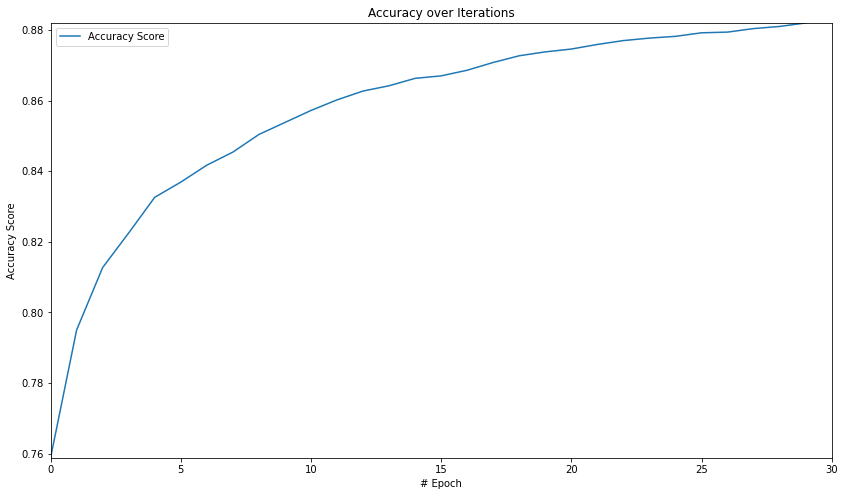

In [31]:
# And run with 30 epochs...
num_epochs=30
tensorflow_classification(
    num_epochs=num_epochs, 
    num_batches=num_batches, 
    batch_size=batch_size, 
    batch_func=mnist_batch_func, 
    optimizer=optimizer,
    test_x=mnist.test.images,
    test_y=mnist.test.labels
)